In [84]:
#importing necessary libs
import pandas as pd 
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [86]:
!pip install pandoc

In [6]:
connection=pymysql.connect(host="localhost",user="root",password="1054",database="minicap")

## Data Exploration

In [82]:
# Query for total records
query_total_records = "SELECT COUNT(*) AS total_records FROM crime_data;"
total_records = pd.read_sql(query_total_records, connection)
print("Total Records:")
print(total_records)


#Query for column names 
query_column_names = "SHOW COLUMNS FROM crime_data;"
column_names = pd.read_sql(query_column_names, connection)
print("\nColumn Name:")
print(column_names)


# Query for unique values
query_unique_values = """
SELECT 
    COUNT(DISTINCT Crm_Cd) AS unique_crime_codes, 
    COUNT(DISTINCT AREA_NAME) AS unique_area_names, 
    COUNT(DISTINCT Status) as unique_status,
    COUNT(DISTINCT Vict_Sex) as unique_sex
FROM crime_data;
"""
unique_values = pd.read_sql(query_unique_values, connection)
print("\n\nUnique Values:")
print(unique_values)

Total Records:
   total_records
0            499

Column Name:
          Field    Type Null Key Default Extra
0         DR_NO     int  YES        None      
1     Date_Rptd    text  YES        None      
2      DATE_OCC    text  YES        None      
3     AREA_NAME    text  YES        None      
4        Crm_Cd     int  YES        None      
5   Crm_Cd_Desc    text  YES        None      
6      Vict_Age     int  YES        None      
7      Vict_Sex    text  YES        None      
8   Premis_Desc    text  YES        None      
9        Status    text  YES        None      
10     Location    text  YES        None      
11          LAT  double  YES        None      
12          LON  double  YES        None      


Unique Values:
   unique_crime_codes  unique_area_names  unique_status  unique_sex
0                  42                 19              4           4


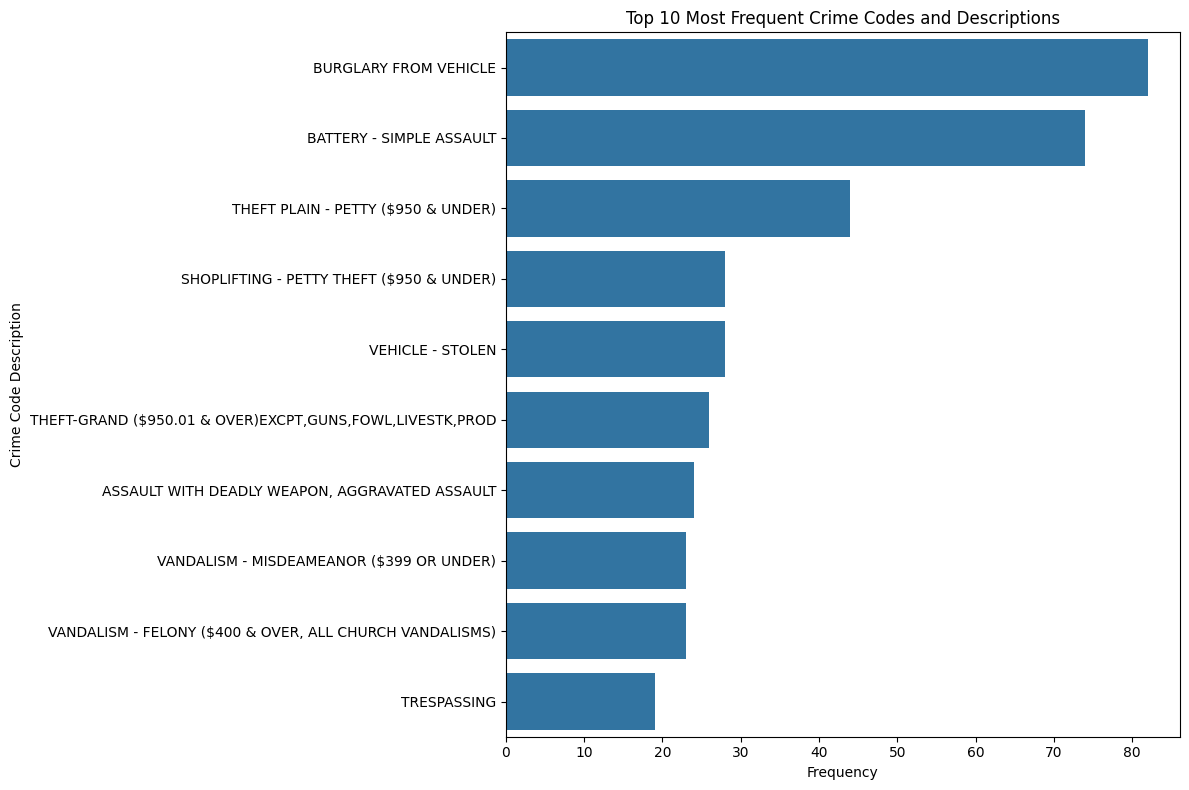

In [80]:
# SQL query to count occurrences of each crime code
query = """
SELECT Crm_Cd_Desc, COUNT(*) AS Count 
FROM crime_data 
GROUP BY Crm_Cd_Desc 
ORDER BY Count DESC 
LIMIT 10;
"""
crime_code_counts_desc = pd.read_sql(query, connection)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Crm_Cd_Desc', data=crime_code_counts_desc)
plt.title('Top 10 Most Frequent Crime Codes and Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Crime Code Description')
plt.tight_layout()
plt.show()


## Temporal Analysis

C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\2806712768.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temporal_data_simple = pd.read_sql(query_temporal_analysis, connection)


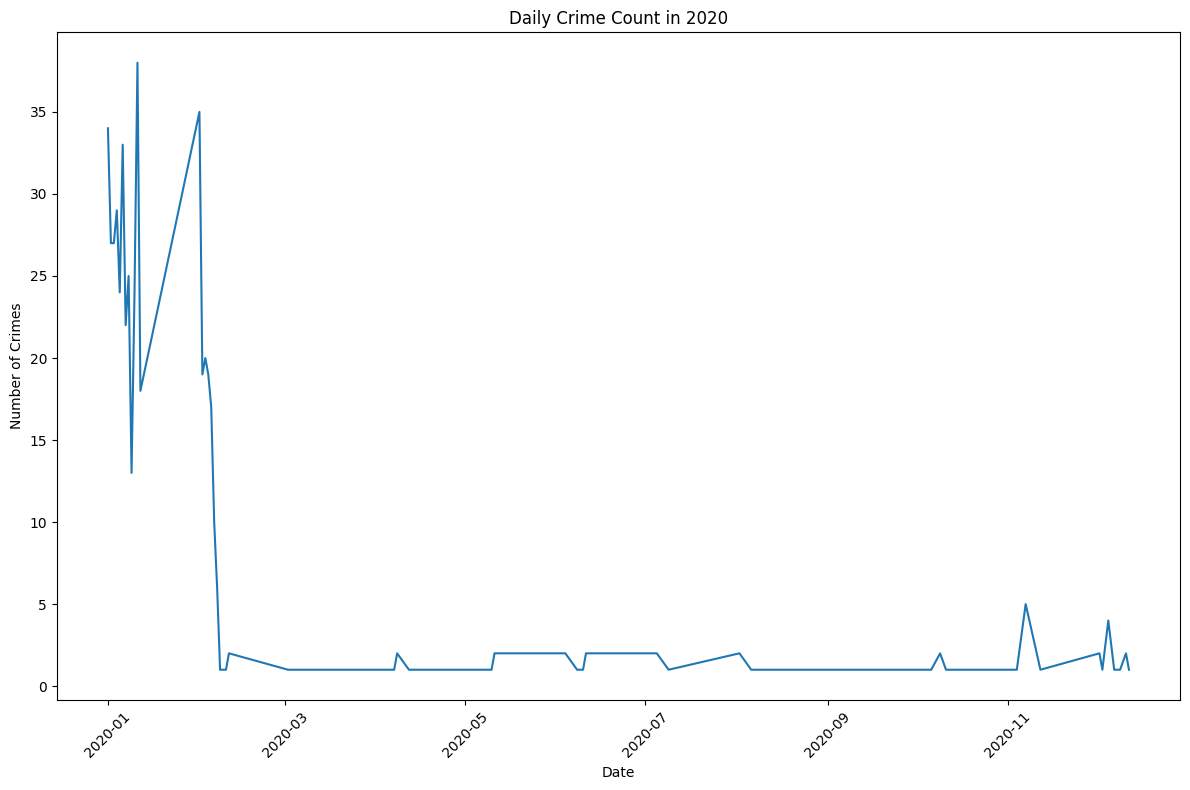

In [27]:


# Temporal Analysis SQL query
query_temporal_analysis = """
SELECT DATE_OCC, COUNT(*) AS Crime_Count 
FROM crime_data 
GROUP BY DATE_OCC;
"""
temporal_data_simple = pd.read_sql(query_temporal_analysis, connection)



# Converting DATE_OCC to datetime to extract the year and month for plotting
temporal_data_simple['DATE_OCC'] = pd.to_datetime(temporal_data_simple['DATE_OCC'])
temporal_data_simple['Month'] = temporal_data_simple['DATE_OCC'].dt.month
temporal_data_simple['Year'] = temporal_data_simple['DATE_OCC'].dt.year

# Assuming all data is from 2020, directly aggregate crime counts by DATE_OCC
crime_count_daily = temporal_data_simple.groupby('DATE_OCC')['Crime_Count'].sum().reset_index()

# Plotting daily crime counts
plt.figure(figsize=(12, 8))
sns.lineplot(x='DATE_OCC', y='Crime_Count', data=crime_count_daily)
plt.title('Daily Crime Count in 2020')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

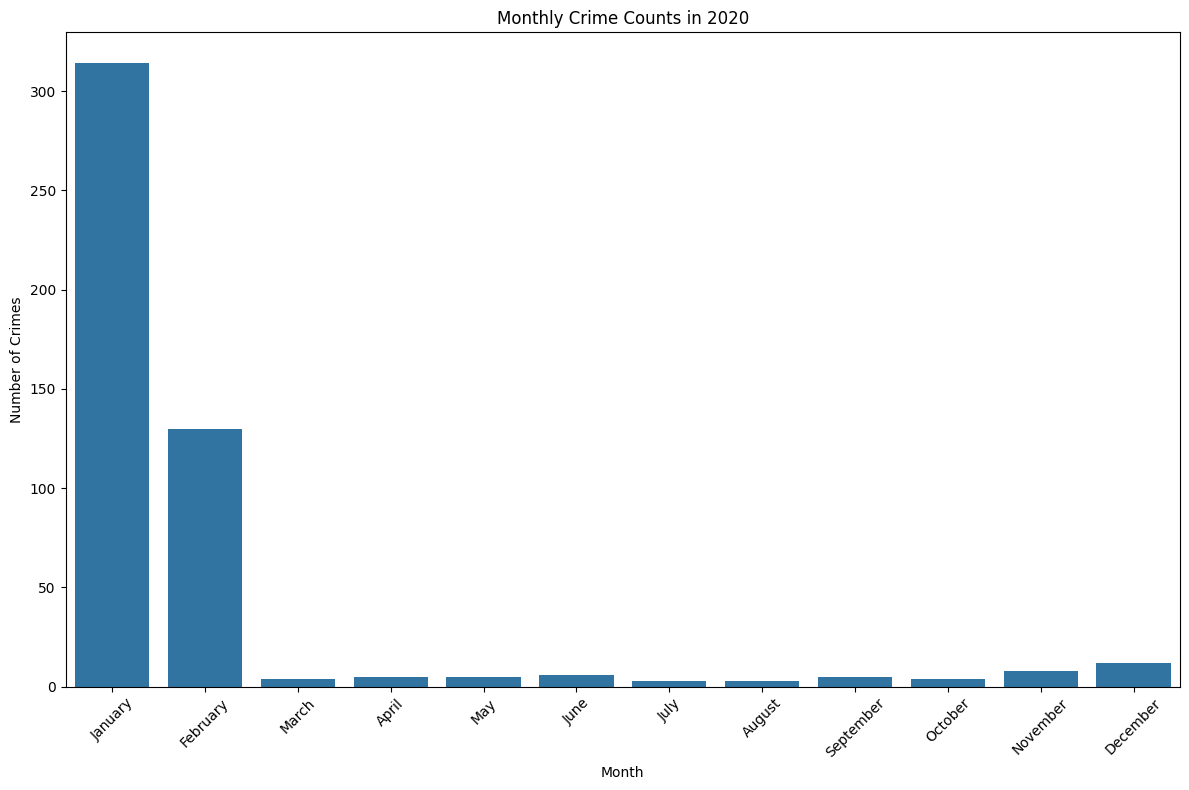

In [28]:
# Convert DATE_OCC to datetime if not already done
temporal_data_simple['DATE_OCC'] = pd.to_datetime(temporal_data_simple['DATE_OCC'])

# Extracting year and month for binning
temporal_data_simple['Year'] = temporal_data_simple['DATE_OCC'].dt.year
temporal_data_simple['Month'] = temporal_data_simple['DATE_OCC'].dt.month

# Aggregating by month for the year 2020
monthly_crime_counts = temporal_data_simple.groupby(['Year', 'Month']).agg({'Crime_Count':'sum'}).reset_index()

# Filtering for 2020 if necessary
monthly_crime_counts_2020 = monthly_crime_counts[monthly_crime_counts['Year'] == 2020]

# Converting month number to month names for readability
monthly_crime_counts_2020['Month_Name'] = monthly_crime_counts_2020['Month'].apply(lambda x: pd.to_datetime(f'{x}', format='%m').strftime('%B'))

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Month_Name', y='Crime_Count', data=monthly_crime_counts_2020)
plt.title('Monthly Crime Counts in 2020')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Spatial Analysis

In [38]:
# SQL query for spatial data
query_spatial_data = "SELECT LAT, LON, AREA_NAME FROM crime_data WHERE LAT IS NOT NULL AND LON IS NOT NULL AND Location IS NOT NULL;"
spatial_data = pd.read_sql(query_spatial_data, connection)
spatial_data.nunique()

C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_7592\746844319.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spatial_data = pd.read_sql(query_spatial_data, connection)


LAT          35
LON          29
AREA_NAME    19
dtype: int64

Index(['LAT', 'LON', 'AREA_NAME'], dtype='object')


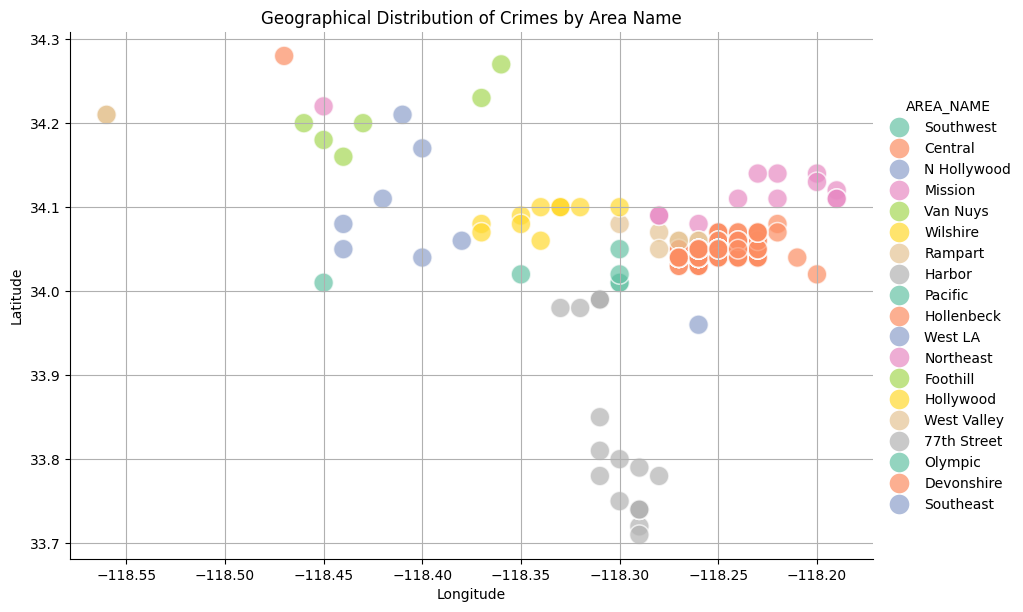

In [49]:
print(spatial_data.columns)

sns.relplot(data= spatial_data, x='LON', y='LAT', hue='AREA_NAME',palette='Set2', kind='scatter',  s=200, alpha=0.7, height=6, aspect=1.5)

plt.title('Geographical Distribution of Crimes by Area Name')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend(title='Area Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
#plt.tight_layout()
plt.show()

In [55]:
import folium
from folium.plugins import HeatMap
import seaborn as sns

# Assuming 'spatial_data' is the DataFrame containing the crime data
map_center = [spatial_data['LAT'].mean(), spatial_data['LON'].mean()]
crime_map_with_popup = folium.Map(location=map_center, zoom_start=12)

# Add a heatmap to the map
HeatMap(data=spatial_data[['LAT', 'LON']], radius=10).add_to(crime_map_with_popup)

# Adding colored dots for each crime location with popups showing LAT or LON
for idx, row in spatial_data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=2,
        color=color_dict[row['AREA_NAME']],  # Referencing the color_dict from the previous code
        fill=True,
        fill_color=color_dict[row['AREA_NAME']],
        popup=f"Lat, Lon: {row['LAT']}, {row['LON']}"  # Popup showing lat or lon
    ).add_to(crime_map_with_popup)

# Display the map with popups
crime_map_with_popup


## Victim Demographics

C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\1639884207.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  victim_demo_data = pd.read_sql(query_victim_demo, connection)


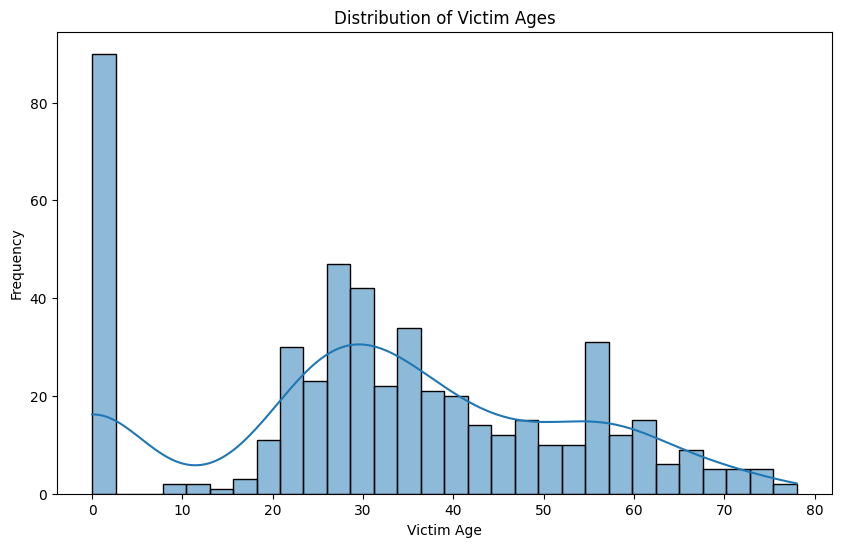

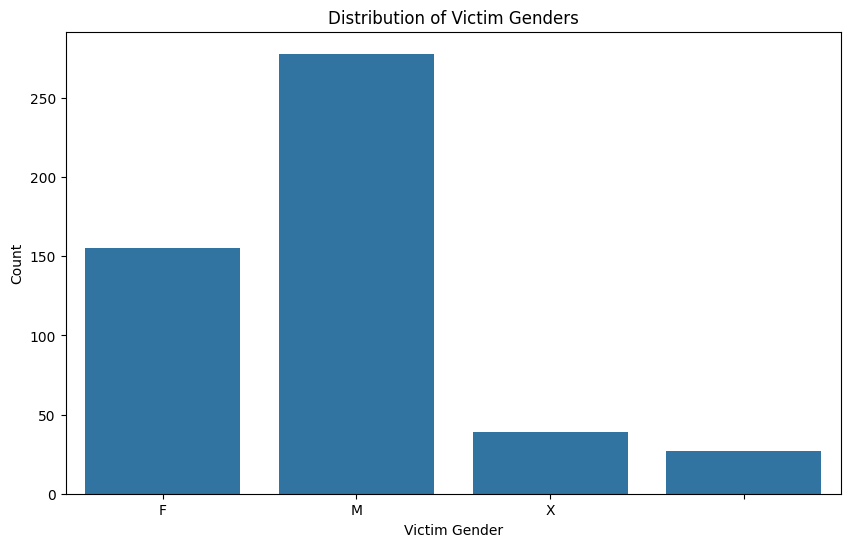

In [39]:
# Assuming database connection 'connection' is already established

# Query for victim ages and genders
query_victim_demo = "SELECT Vict_Age, Vict_Sex FROM crime_data WHERE Vict_Age IS NOT NULL AND Vict_Sex IS NOT NULL;"
victim_demo_data = pd.read_sql(query_victim_demo, connection)

# Visualization of Victim Ages
plt.figure(figsize=(10, 6))
sns.histplot(victim_demo_data['Vict_Age'], bins=30, kde=True)
plt.title('Distribution of Victim Ages')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.show()

# Visualization of Victim Genders
plt.figure(figsize=(10, 6))
sns.countplot(x='Vict_Sex', data=victim_demo_data)
plt.title('Distribution of Victim Genders')
plt.xlabel('Victim Gender')
plt.ylabel('Count')
plt.show()


C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\2239392550.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  common_premises_data = pd.read_sql(query_common_premises, connection)


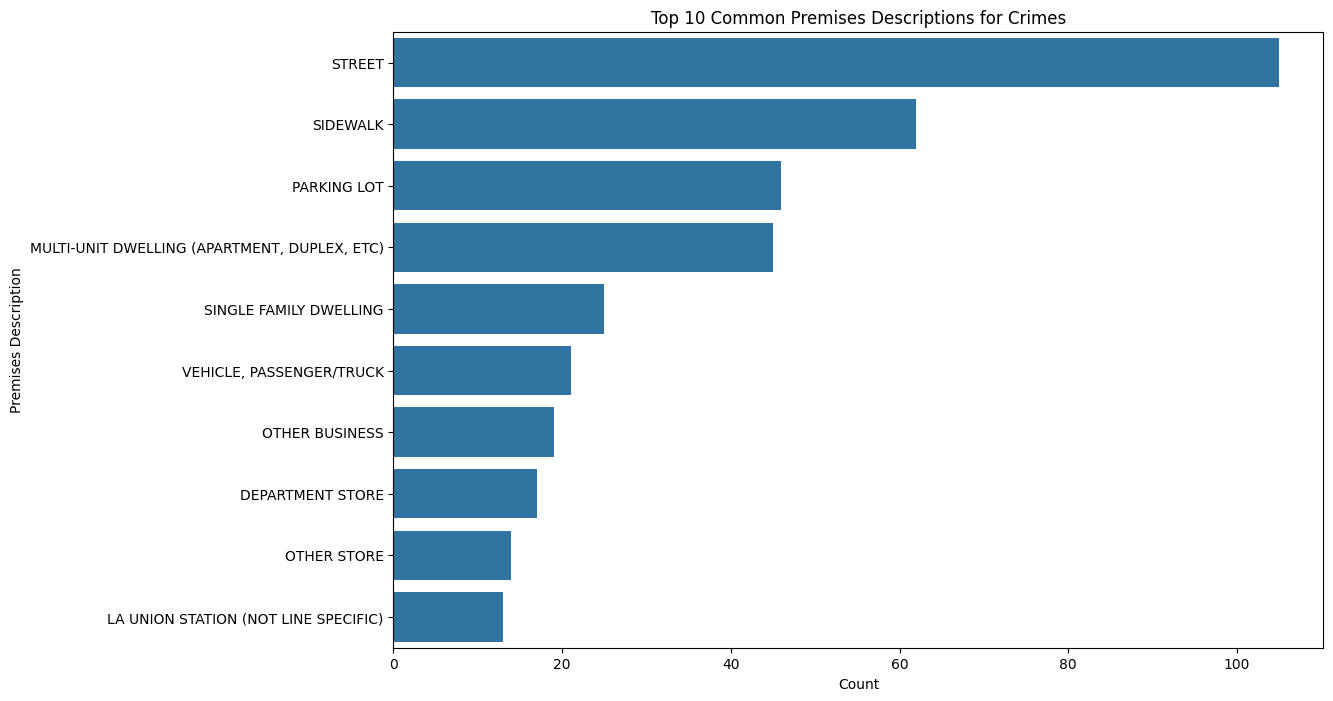

In [40]:
# Query for common premises descriptions
query_common_premises = "SELECT Premis_Desc, COUNT(*) AS Count FROM crime_data WHERE Premis_Desc IS NOT NULL GROUP BY Premis_Desc ORDER BY Count DESC;"
common_premises_data = pd.read_sql(query_common_premises, connection)

# Taking top 10 for visualization
top_premises = common_premises_data.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Premis_Desc', data=top_premises)
plt.title('Top 10 Common Premises Descriptions for Crimes')
plt.xlabel('Count')
plt.ylabel('Premises Description')
plt.show()


### Status Analysis

C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\1047431433.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  status_data = pd.read_sql(query_status_analysis, connection)


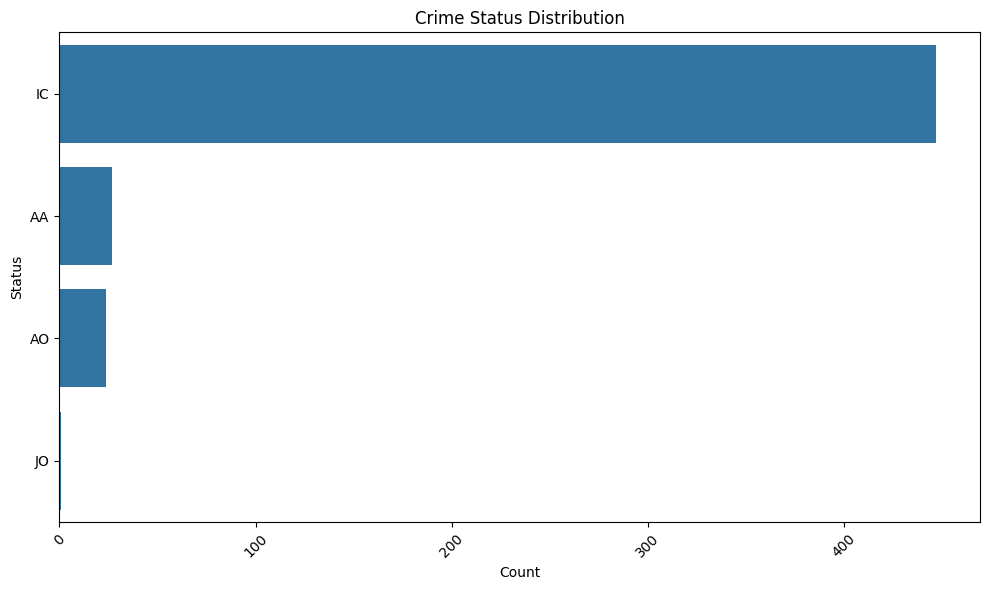

In [41]:
# Assuming the database connection 'connection' is already established for status analysis

# SQL query for crime status data
query_status_analysis = """
SELECT Status, COUNT(*) AS Count 
FROM crime_data 
GROUP BY Status 
ORDER BY Count DESC;
"""
status_data = pd.read_sql(query_status_analysis, connection)

# Visualization of Crime Status Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Status', data=status_data)
plt.title('Crime Status Distribution')
plt.xlabel('Count')
plt.ylabel('Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# This block assumes that the SQL query has been executed and status_data contains the result.
# Replace 'connection' with your actual database connection variable.


# Questions

## 1. Spatial Analysis: Identifying Geographical Hotspots

In [1]:
query = "SELECT LAT, LON, Location FROM crime_data WHERE LAT IS NOT NULL AND LON IS NOT NULL;"
spatial_data = pd.read_sql(query, connection)


NameError: name 'pd' is not defined

Index(['LAT', 'LON', 'AREA_NAME'], dtype='object')


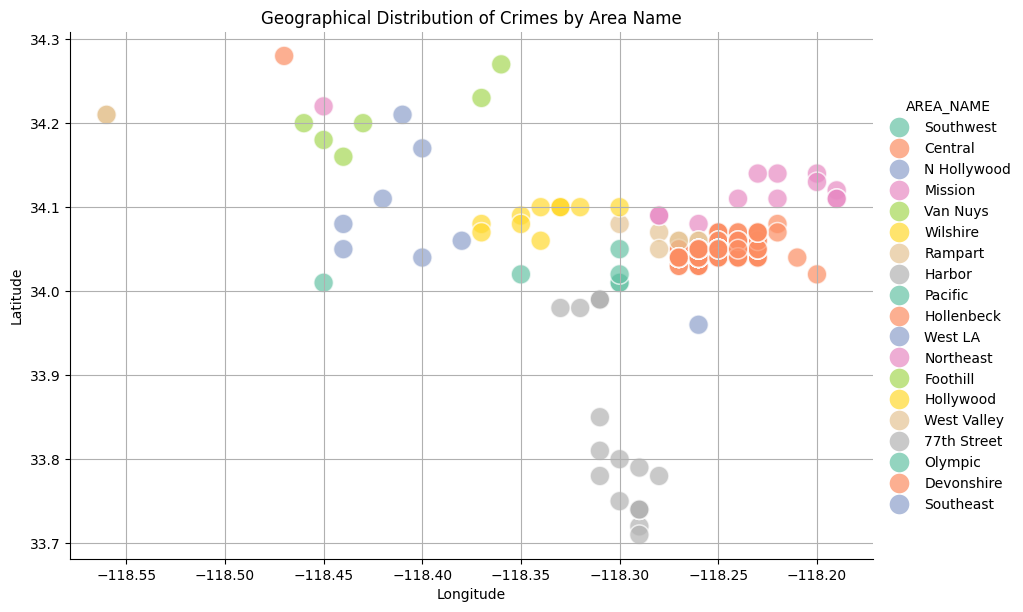

In [85]:
print(spatial_data.columns)

sns.relplot(data= spatial_data, x='LON', y='LAT', hue='AREA_NAME',palette='Set2', kind='scatter',  s=200, alpha=0.7, height=6, aspect=1.5)

plt.title('Geographical Distribution of Crimes by Area Name')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend(title='Area Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
#plt.tight_layout()
plt.show()


### Insight: There are clear clusters where crime incidents are densely concentrated, suggesting specific neighborhoods or areas experience higher crime rates. These hotspots may require targeted interventions and resources.

## 2. Victim Demographics: Age Distribution and Gender Difference

In [65]:
query = "SELECT Vict_Age, Vict_Sex FROM crime_data WHERE Vict_Age IS NOT NULL AND Vict_Sex IS NOT NULL;"
victim_demo_data = pd.read_sql(query, connection)


C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\351916964.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  victim_demo_data = pd.read_sql(query, connection)


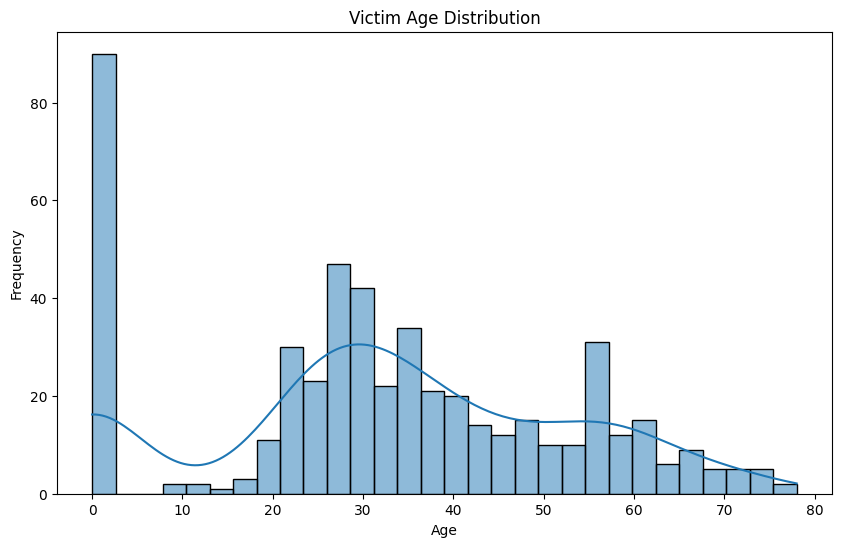

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(victim_demo_data['Vict_Age'], bins=30, kde=True)
plt.title('Victim Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


### Insight: The age distribution shows a broad range of victim ages, with a notable peak in young to middle-aged adult populations. This implies that crime affects a wide demographic but particularly impacts younger individuals

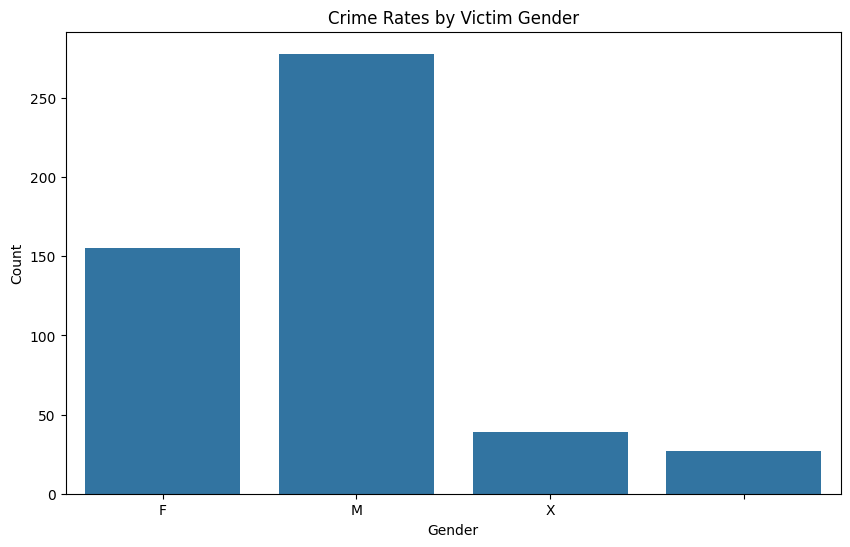

In [67]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Vict_Sex', data=victim_demo_data)
plt.title('Crime Rates by Victim Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


### Insight: The comparison of crime rates by gender reveals a higher number of male victims compared to female and other genders. 

## 3. Location Analysis: Common Crime Locations

In [60]:
query = "SELECT Location, COUNT(*) AS Count FROM crime_data GROUP BY Location ORDER BY Count DESC LIMIT 10;"
location_data = pd.read_sql(query, connection)


C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\3027911528.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_data = pd.read_sql(query, connection)


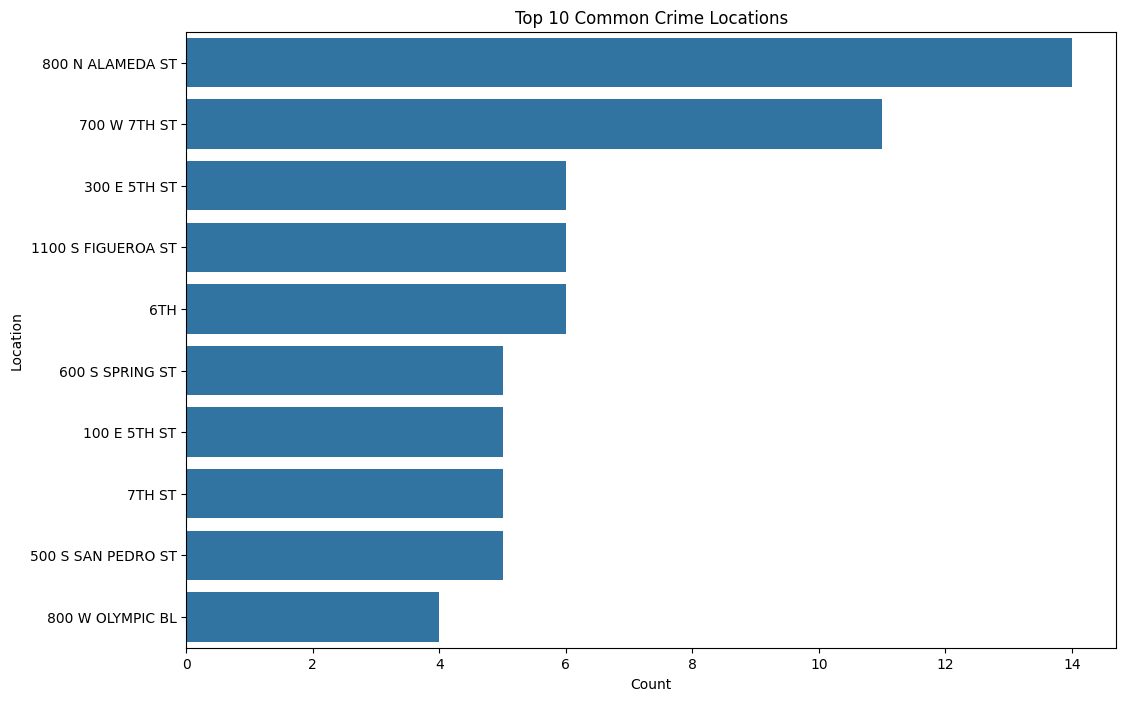

In [61]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Location', data=location_data)
plt.title('Top 10 Common Crime Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()


### Insight: 800 N ALAMEDA ST and 700 W 7TH ST are the most reported crime locations, followed by 1100 S FIGUEROA ST and 300 E 5TH ST, indicating these spots as frequent sites for criminal incidents.

## 4. Crime Code Analysis: Distribution of Reported Crimes

In [74]:
query = """
SELECT Location, COUNT(*) AS Count
FROM crime_data
GROUP BY Location
ORDER BY Count DESC
LIMIT 10;
"""
# Execute the query
location_counts = pd.read_sql(query, connection)

C:\Users\Mohit Manghnani\AppData\Local\Temp\ipykernel_12056\3239087023.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_counts = pd.read_sql(query, connection)


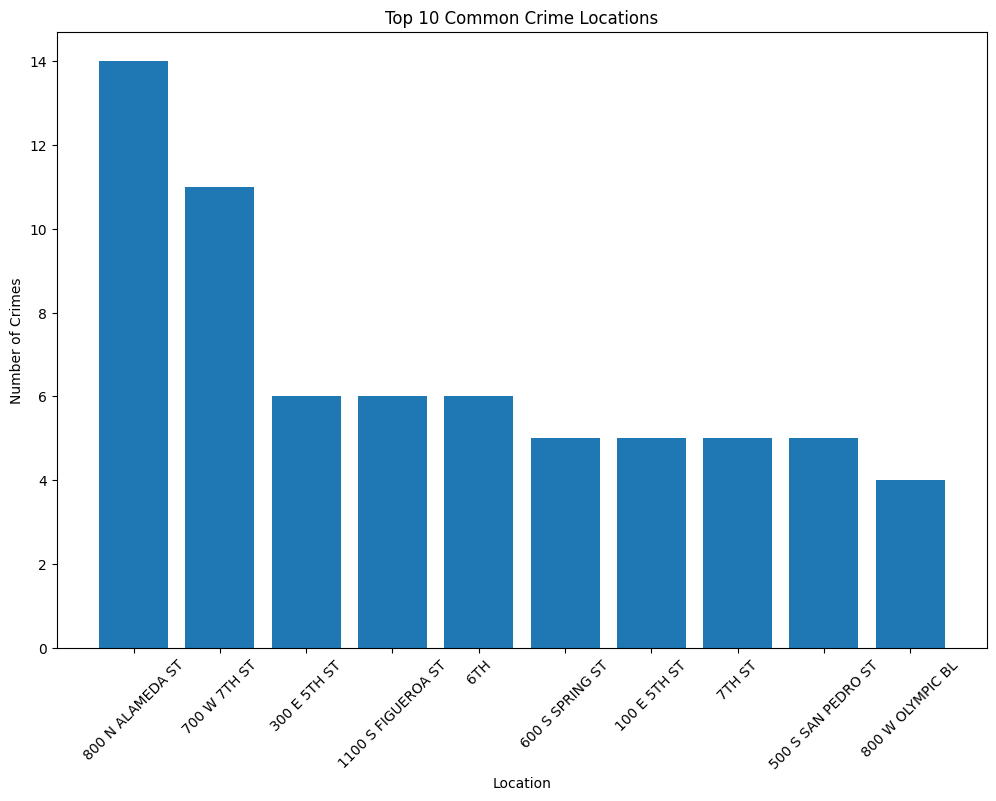

In [75]:
# Plotting the top 10 common crime locations
plt.figure(figsize=(12, 8))
plt.bar(location_counts['Location'], location_counts['Count'])
plt.title('Top 10 Common Crime Locations')
plt.xlabel('Location')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()


### Insight: The prevalence of Battery - Simple Assault (624) and Theft (440, 442) underscores a significant concern with personal safety and property crimes, indicating a need for preventive strategies and community awareness programs.